In [74]:
import os
import re
import numpy as np
import pandas as pd
import tensorflow as tf
import warnings
import tensorflow_hub as hub
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

In [75]:
import pandas as pd
# Read excel file with sheet name
df = pd.read_excel('/content/Clean_Abdomen_Data.xlsx', sheet_name=['Source of Truth','Key Words','Description'])

In [76]:
# Get DataFrame from Dict
source_df = df.get('Source of Truth')
key_words_df = df.get('Key Words')
descriptions_df = df.get('Description')

In [77]:
source_df

,Protocol,Protocol_Name
0,1,Liver
1,2,Liver Fe2 + quantification
2,3,Liver Ablatoin
3,4,Liver - Primovist
4,5,Bile Leak - Primovist
5,6,Pancreas/MRCP
6,7,MRCP
7,8,Kidneys with Subtractions
8,9,Adrenals
9,10,Rectal Ca Staging


## **Remove Old Cols From the DataFrame**

In [78]:
source_df.head()

,Protocol,Protocol_Name
0,1,Liver
1,2,Liver Fe2 + quantification
2,3,Liver Ablatoin
3,4,Liver - Primovist
4,5,Bile Leak - Primovist


In [79]:
key_words_df = key_words_df[['Protocol', 'Keys']]
key_words_df.head()

,Protocol,Keys
0,1,mets
1,1,metastisis
2,1,cirrohsis
3,4,primovist
4,1,jaundice


In [80]:
descriptions_df = descriptions_df[['Protocol_Name', 'Description']]
descriptions_df.head()

,Protocol_Name,Description
0,LIver,MRI Liver ct for prostate cancerstaging shows ...
1,Pancreatitis,chronic pancreatitis?
2,Female Pelvis,2017 simple ovarian cyst pt c/o pain and heavy...
3,Pancrease/MRCP,follow up pancreatic cysts
4,LIVER MRCP,"IBD with cholestatic LFTS r/o PSC, patient sta..."


## **Change Native Data Types**
> Need to verify Excel format so that no errors are produced, very important step.

In [81]:
source_df['Protocol'] = source_df['Protocol'].astype(int)
source_df['Protocol_Name'] = source_df['Protocol_Name'].astype(str)

key_words_df['Protocol'] = key_words_df['Protocol'].astype(int)
key_words_df['Keys'] = key_words_df['Keys'].astype(str)

descriptions_df['Protocol_Name'] = descriptions_df['Protocol_Name'].astype(str)
descriptions_df['Description'] = descriptions_df['Description'].astype(str)

## **Data Preprocessing Step #1: key_words_df** 

In [82]:
key_words_df['Protocol'].value_counts()

1     53
14    40
6     26
13    14
12    11
20    10
11    10
7      9
19     9
3      6
2      6
8      5
4      5
10     4
15     4
9      4
5      2
18     2
16     1
Name: Protocol, dtype: int64

<Axes: ylabel='Protocol'>

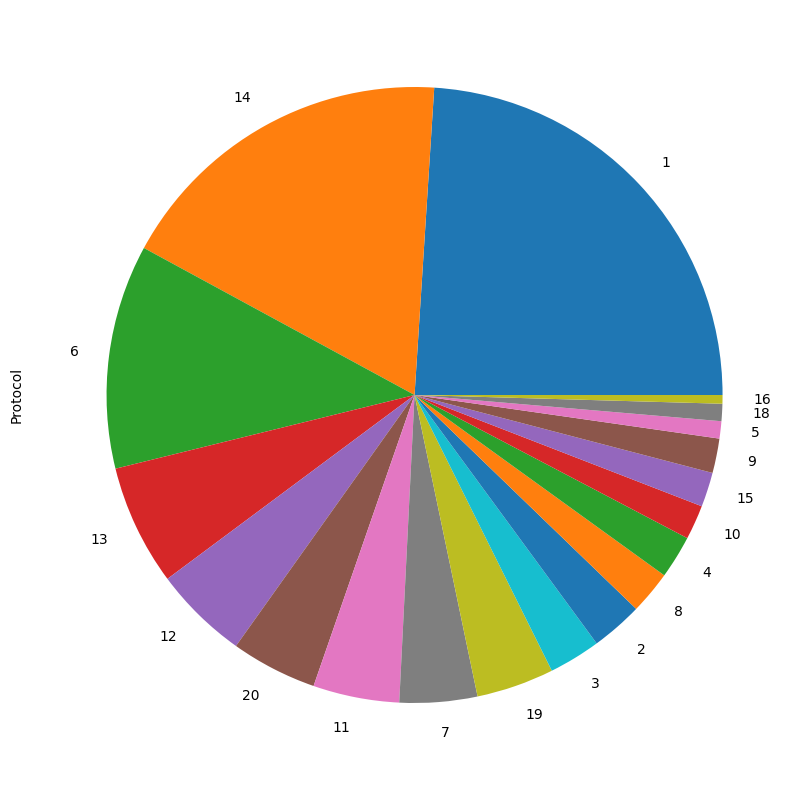

In [83]:
# Frequency of each protocol in the Abdomen Data Set
key_words_df['Protocol'].value_counts().plot(kind='pie', y='Protocol', figsize=(10, 10))

In [84]:
protocol_count = key_words_df.Protocol.max()
protocol_count

20

In [85]:
# Partition by protocol - counts from index 0 - 19 -> 20 total *********
grouped = key_words_df.groupby(key_words_df.Protocol)
print(len(grouped), type(grouped))

19 <class 'pandas.core.groupby.generic.DataFrameGroupBy'>


## **Creating Total Key Word Search for each Protocol**

In [86]:
''' 
legacy version: March 2023

def converted_lst(n):
  try:
    df = grouped.get_group(n)
    df = df.Keys.tolist()
    return list(df)
  except:
    pass

df_hm = {}
for i in range(1, protocol_count + 1):
  key = str(str('KeyWords_p') + str(i))
  df_hm[key] = converted_lst(i)

'''

def converted_lst(n):
  try:
    df = grouped.get_group(n)
    lst = df.Keys.tolist()
    final_str = ' '.join(lst)
    print(final_str)

    return final_str

  except:
    pass

df_hm = {}
for i in range(1, protocol_count + 1):
  key = str(i)
  # key = str(str('TotalKeyWords_Protocol#') + str(i))
  df_hm[key] = converted_lst(i)

mets metastisis cirrohsis jaundice enlarged spleen hemangioma ascities LLQ pain RLQ pain URQ pain ULQ pain Cholestatic Mass liver lesions liver mass hcc lesions liver fatty liver hepatitis B neoplasm dysplastic nodule nodule nodules liver enzymes hypoechoic mass hbv lymph nodes serpiginous hypoechoic avascular multiple septations liver mets hepatoma hemangioma hbv liver transplant hypovascular lesion liver metastases elevated liver enzymes benign adenocarcinoma liver carcinoid lobe abscess Lesion psc lft lfts trauma acute abdominal pain cystic Cyst
iron quantification iron Dilated ducts iron iron overload hemochromatosis
rfa radio frequency ablation rfa liver lesion tace Lesion cystic
primovist adenomas fnh focal nodular hyperplasia Lesion
bile leak adenoma
pancreatitis impn Pancreas MRCP chronic pancreatitis pancreatic cysts pancreatic cancer intraductal Dilated bile ducts cbd pancreatic lesion pancreatic cyst multicystic pancreatic mucinous neoplasm tail pancreas head pseudocyst chol

In [87]:
# Each Row Above is associated with protocol number, we have successfully created bag of key words for each protocol for our engine
for key,value in df_hm.items(): # print samples
    print(f"Protocol#{key} -> key_word_bag: {value}")

Protocol#1 -> key_word_bag: mets metastisis cirrohsis jaundice enlarged spleen hemangioma ascities LLQ pain RLQ pain URQ pain ULQ pain Cholestatic Mass liver lesions liver mass hcc lesions liver fatty liver hepatitis B neoplasm dysplastic nodule nodule nodules liver enzymes hypoechoic mass hbv lymph nodes serpiginous hypoechoic avascular multiple septations liver mets hepatoma hemangioma hbv liver transplant hypovascular lesion liver metastases elevated liver enzymes benign adenocarcinoma liver carcinoid lobe abscess Lesion psc lft lfts trauma acute abdominal pain cystic Cyst
Protocol#2 -> key_word_bag: iron quantification iron Dilated ducts iron iron overload hemochromatosis
Protocol#3 -> key_word_bag: rfa radio frequency ablation rfa liver lesion tace Lesion cystic
Protocol#4 -> key_word_bag: primovist adenomas fnh focal nodular hyperplasia Lesion
Protocol#5 -> key_word_bag: bile leak adenoma
Protocol#6 -> key_word_bag: pancreatitis impn Pancreas MRCP chronic pancreatitis pancreatic 

In [88]:
final_df = pd.DataFrame(list(df_hm.items()),columns = ['Protocol','Key_Word_Total'])
final_df

,Protocol,Key_Word_Total
0,1,mets metastisis cirrohsis jaundice enlarged sp...
1,2,iron quantification iron Dilated ducts iron ir...
2,3,rfa radio frequency ablation rfa liver lesion ...
3,4,primovist adenomas fnh focal nodular hyperplas...
4,5,bile leak adenoma
5,6,pancreatitis impn Pancreas MRCP chronic pancre...
6,7,mrcp mrcp radiologist reccomend mrcp radiologi...
7,8,kidney infection renal amls amls Lesion
8,9,adrenal gland adreanls adrenal gland Lesion
9,10,Rectal Ca Rectal Cancer Staging stage


## **Adding Protocol Names into the DataFrame**

In [89]:
# Need to perform an Inner-Join between Protocols in order to draw in the Protocol_name info out final_df
final_df['Protocol'] = final_df['Protocol'].astype(int)
final_df['Key_Word_Total'] = final_df['Key_Word_Total'].astype(str)

# result = pd.concat([final_df, source_df], axis=1, join="inner")
final_df = pd.merge(final_df, source_df, how='inner',
                    left_on=['Protocol'],
                    right_on=['Protocol'])

In [90]:
final_df = final_df[['Protocol','Protocol_Name','Key_Word_Total']]

In [91]:
final_df

,Protocol,Protocol_Name,Key_Word_Total
0,1,Liver,mets metastisis cirrohsis jaundice enlarged sp...
1,2,Liver Fe2 + quantification,iron quantification iron Dilated ducts iron ir...
2,3,Liver Ablatoin,rfa radio frequency ablation rfa liver lesion ...
3,4,Liver - Primovist,primovist adenomas fnh focal nodular hyperplas...
4,5,Bile Leak - Primovist,bile leak adenoma
5,6,Pancreas/MRCP,pancreatitis impn Pancreas MRCP chronic pancre...
6,7,MRCP,mrcp mrcp radiologist reccomend mrcp radiologi...
7,8,Kidneys with Subtractions,kidney infection renal amls amls Lesion
8,9,Adrenals,adrenal gland adreanls adrenal gland Lesion
9,10,Rectal Ca Staging,Rectal Ca Rectal Cancer Staging stage


## **Data Preprocessing Step #2: Description** 

In [92]:
descriptions_df.head()

,Protocol_Name,Description
0,LIver,MRI Liver ct for prostate cancerstaging shows ...
1,Pancreatitis,chronic pancreatitis?
2,Female Pelvis,2017 simple ovarian cyst pt c/o pain and heavy...
3,Pancrease/MRCP,follow up pancreatic cysts
4,LIVER MRCP,"IBD with cholestatic LFTS r/o PSC, patient sta..."


In [93]:
descriptions_df.describe()

,Protocol_Name,Description
count,148,148
unique,51,147
top,liver,f/u pancreatic cysts
freq,25,2


In [94]:
descriptions_df['Protocol_Name'].value_counts()

liver                                                                 25
pancreas                                                              14
Liver                                                                 11
female pelvis                                                         10
liver/MRCP                                                             9
prostate                                                               7
MRCP                                                                   5
liver                                                                  4
female pelvis                                                          4
enterography                                                           4
pancreas/mrcp                                                          3
kidneys                                                                3
Pancrease/MRCP                                                         3
Female pelvis                                      

<Axes: ylabel='Protocol_Name'>

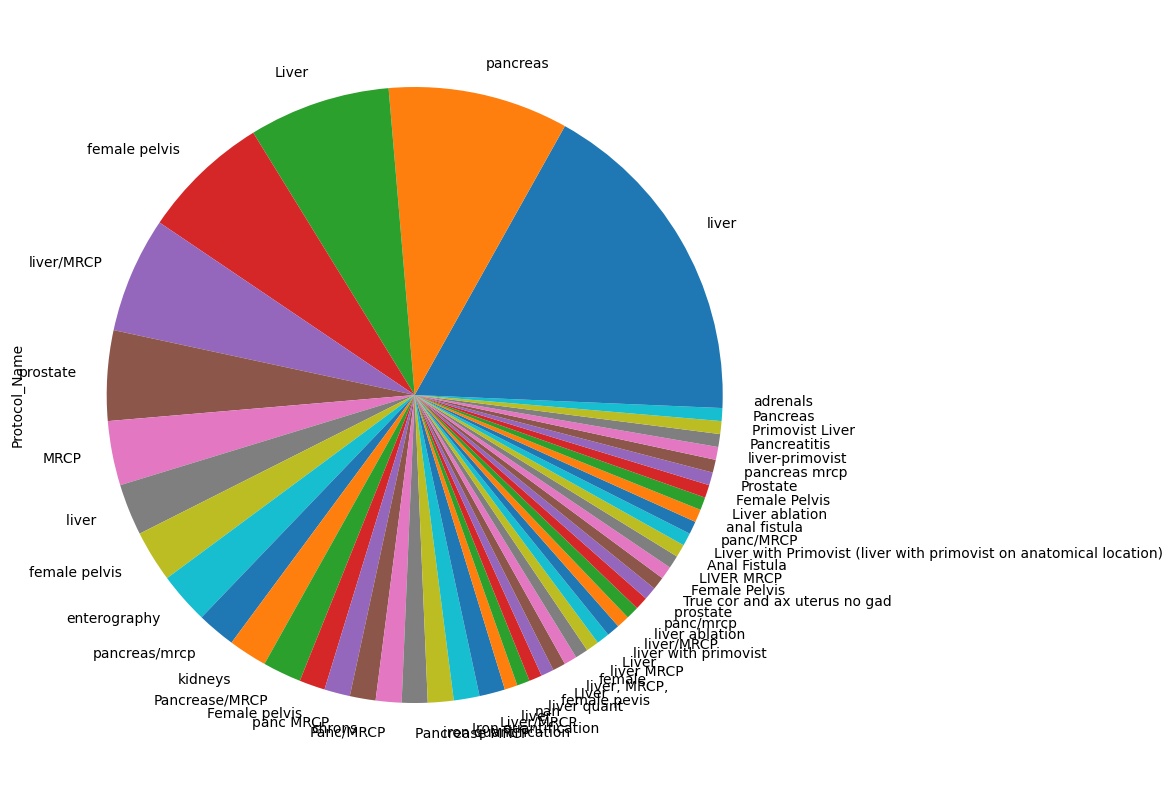

In [95]:
descriptions_df['Protocol_Name'].value_counts().plot(kind='pie', y='Protocol_Name', figsize=(10, 10))

In [96]:
name_count = descriptions_df.Protocol_Name.count()
name_count

148

In [97]:
# Replace Uncategorized Row Records -> Renaming convention for coherency of the system
descriptions_df.Protocol_Name = descriptions_df.Protocol_Name.str.replace('Liver','liver')
descriptions_df.Protocol_Name = descriptions_df.Protocol_Name.str.replace('liver','liver')
descriptions_df.Protocol_Name = descriptions_df.Protocol_Name.str.replace('liver ','liver')
descriptions_df.Protocol_Name = descriptions_df.Protocol_Name.str.replace('LIver ','liver') 

descriptions_df.Protocol_Name = descriptions_df.Protocol_Name.str.replace('liverMRCP','liver/MRCP')
descriptions_df.Protocol_Name = descriptions_df.Protocol_Name.str.replace('liver, MRCP,','liver/MRCP')
descriptions_df.Protocol_Name = descriptions_df.Protocol_Name.str.replace('liver/MRCP ','liver/MRCP')
descriptions_df.Protocol_Name = descriptions_df.Protocol_Name.str.replace('LIVER MRCP','liver/MRCP')

descriptions_df.Protocol_Name = descriptions_df.Protocol_Name.str.replace('pancreas/mrcp','pancreas/MRCP')
descriptions_df.Protocol_Name = descriptions_df.Protocol_Name.str.replace('Panc/MRCP','pancreas/MRCP')
descriptions_df.Protocol_Name = descriptions_df.Protocol_Name.str.replace('Pancrease MRCP','pancreas/MRCP')
descriptions_df.Protocol_Name = descriptions_df.Protocol_Name.str.replace('Panc MRCP','pancreas/MRCP')
descriptions_df.Protocol_Name = descriptions_df.Protocol_Name.str.replace('Pancrease/MRCP','pancreas/MRCP')
descriptions_df.Protocol_Name = descriptions_df.Protocol_Name.str.replace('panc MRCP','pancreas/MRCP')

In [98]:
descriptions_df['Protocol_Name'].value_counts()

liver                                                               41
liver/MRCP                                                          15
pancreas                                                            14
pancreas/MRCP                                                       12
female pelvis                                                       10
prostate                                                             7
MRCP                                                                 5
female pelvis                                                        4
enterography                                                         4
kidneys                                                              3
iron quantification                                                  2
Female pelvis                                                        2
chrons                                                               2
Iron quantification                                                  2
livera

In [99]:
# liver             42 count
descriptions_df.Protocol_Name = descriptions_df.Protocol_Name.str.replace('liver', '1')

# liver/MRCP        15 count
descriptions_df.Protocol_Name = descriptions_df.Protocol_Name.str.replace('liver/MRCP', '19')

# pancreas          14 count
descriptions_df.Protocol_Name = descriptions_df.Protocol_Name.str.replace('pancreas', '6')

# pancreas/MRCP     12 count
descriptions_df.Protocol_Name = descriptions_df.Protocol_Name.str.replace('pancreas/MRCP', '6')

# female pelvis     10 count
descriptions_df.Protocol_Name = descriptions_df.Protocol_Name.str.replace('female pelvis', '14')

# prostate           7 count
descriptions_df.Protocol_Name = descriptions_df.Protocol_Name.str.replace('prostate', '13')

# MRCP               5 count
descriptions_df.Protocol_Name = descriptions_df.Protocol_Name.str.replace('MRCP', '7')

# female pelvis      4 count
descriptions_df.Protocol_Name = descriptions_df.Protocol_Name.str.replace('female pelvis ', '14')

# enterography       4 count
descriptions_df.Protocol_Name = descriptions_df.Protocol_Name.str.replace('enterography', '12')

In [100]:
descriptions_df['Protocol_Name'].value_counts()

1                                                           41
1/7                                                         15
6                                                           14
6/7                                                         12
14                                                          10
13                                                           7
7                                                            5
14                                                           4
12                                                           4
kidneys                                                      3
iron quantification                                          2
Female pelvis                                                2
chrons                                                       2
Iron quantification                                          2
1ablation                                                    2
female pevis                                           

In [101]:
descriptions_df['Protocol_Name'].unique()

array(['LIver', 'Pancreatitis', 'Female Pelvis', '6/7', '1/7',
       'Anal Fistula', '1',
       '1with Primovist (1with primovist on anatomical location)',
       'panc/7', 'anal fistula', 'Female pelvis', '7', 'chrons',
       'True cor and ax uterus no gad ', '1ablation', 'Prostate', '14',
       '6 mrcp', '6', '1-primovist', 'panc/mrcp', 'Primovist 1',
       'Pancreas', 'Female Pelvis ', '14 ', '13 ', 'kidneys',
       'female pevis', 'nan', '1quant', '1 ', '13', 'female', '12',
       '1with primovist', 'iron quantification', 'Iron quantification',
       'adrenals'], dtype=object)

In [102]:
descriptions_df.Protocol_Name = descriptions_df.Protocol_Name.str.replace('6/7', '19')
descriptions_df.Protocol_Name = descriptions_df.Protocol_Name.str.replace('1/7', '6')

In [103]:
descriptions_df['Protocol_Name'].value_counts()

1                                                           41
6                                                           29
19                                                          12
14                                                          10
13                                                           7
7                                                            5
14                                                           4
12                                                           4
kidneys                                                      3
iron quantification                                          2
Female pelvis                                                2
chrons                                                       2
Iron quantification                                          2
1ablation                                                    2
1quant                                                       1
female pevis                                           

In [104]:
descriptions_df.rename(columns = {'Protocol_Name':'Protocol'}, inplace = True)
descriptions_df

,Protocol,Description
0,LIver,MRI Liver ct for prostate cancerstaging shows ...
1,Pancreatitis,chronic pancreatitis?
2,Female Pelvis,2017 simple ovarian cyst pt c/o pain and heavy...
3,19,follow up pancreatic cysts
4,6,"IBD with cholestatic LFTS r/o PSC, patient sta..."
...,...,...
143,Iron quantification,"increase serum ferritin ? hemochromatosis, MR ..."
144,1,ultrasound showing severe diffuse hepatic stea...
145,1,changes on previous MRI suggestive of PSC. Pl...
146,adrenals,"65 y.o. female with RUQ pain, US showed left s..."


## **Final DataFrame - Merge All the Tables**

In [105]:
descriptions_df['Protocol'] = descriptions_df['Protocol'].astype(str)
descriptions_df['Description'] = descriptions_df['Description'].astype(str)

In [106]:
descriptions_df.head()

,Protocol,Description
0,LIver,MRI Liver ct for prostate cancerstaging shows ...
1,Pancreatitis,chronic pancreatitis?
2,Female Pelvis,2017 simple ovarian cyst pt c/o pain and heavy...
3,19,follow up pancreatic cysts
4,6,"IBD with cholestatic LFTS r/o PSC, patient sta..."


In [107]:
final_df.head(50)

,Protocol,Protocol_Name,Key_Word_Total
0,1,Liver,mets metastisis cirrohsis jaundice enlarged sp...
1,2,Liver Fe2 + quantification,iron quantification iron Dilated ducts iron ir...
2,3,Liver Ablatoin,rfa radio frequency ablation rfa liver lesion ...
3,4,Liver - Primovist,primovist adenomas fnh focal nodular hyperplas...
4,5,Bile Leak - Primovist,bile leak adenoma
5,6,Pancreas/MRCP,pancreatitis impn Pancreas MRCP chronic pancre...
6,7,MRCP,mrcp mrcp radiologist reccomend mrcp radiologi...
7,8,Kidneys with Subtractions,kidney infection renal amls amls Lesion
8,9,Adrenals,adrenal gland adreanls adrenal gland Lesion
9,10,Rectal Ca Staging,Rectal Ca Rectal Cancer Staging stage


In [108]:
# Exporting to local machine
final_df.to_csv('/content/final_df.csv', index = None, header=True)